In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math


import nltk
import nltk.stem.porter as pt  
import nltk.stem as ns  
from nltk.corpus import stopwords
import os
from nltk import sent_tokenize
from nltk import word_tokenize

import os
from bs4 import BeautifulSoup
from collections import Counter
import re


from gensim.models import Word2Vec
from sklearn.manifold import TSNE

In [11]:
#Upload
df= pd.read_csv('combined.csv') 
print(df.head())

/Users/jennyyu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (0,7,8,9,12,14,15,16,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


   external_author_id  author  \
0  906000000000000000  10_GOP   
1  906000000000000000  10_GOP   
2  906000000000000000  10_GOP   
3  906000000000000000  10_GOP   
4  906000000000000000  10_GOP   

                                             content   region language  \
0  "We have a sitting Democrat US Senator on tria...  Unknown  English   
1  Marshawn Lynch arrives to game in anti-Trump s...  Unknown  English   
2  Daughter of fallen Navy Sailor delivers powerf...  Unknown  English   
3  JUST IN: President Trump dedicates Presidents ...  Unknown  English   
4  19,000 RESPECTING our National Anthem! #StandF...  Unknown  English   

      publish_date   harvested_date following followers updates  ...  \
0  10/1/2017 19:58  10/1/2017 19:59      1052      9636     253  ...   
1  10/1/2017 22:43  10/1/2017 22:43      1054      9637     254  ...   
2  10/1/2017 22:50  10/1/2017 22:51      1054      9637     255  ...   
3  10/1/2017 23:52  10/1/2017 23:52      1062      9642     256  ...

In [3]:
print(df.shape)

(3433991, 21)


# Data Preview by Columns 

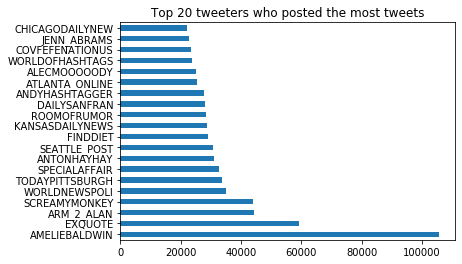

In [126]:
df['author'].value_counts()[:20].plot(kind='barh', title='Top 20 tweeters who posted the most tweets')

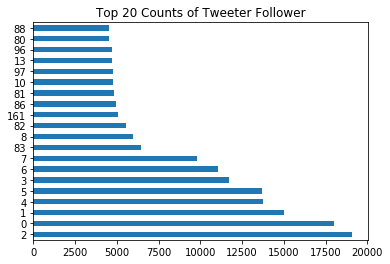

In [110]:
df['followers'].value_counts()[:20].plot(kind='barh', title='Top 20 Counts of Tweeter Follower')

Text(0, 0.5, 'Number of Tweeters')

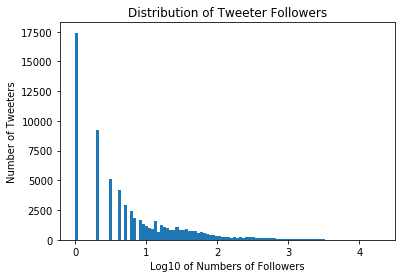

In [42]:
plt.hist(np.log10(df['followers'].value_counts()),bins=100)
plt.title('Distribution of Tweeter Followers')

plt.xlabel("Log10 of Numbers of Followers")
plt.ylabel("Number of Tweeters")

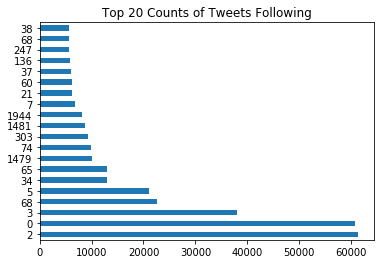

In [111]:
df['following'].value_counts()[:20].plot(kind='barh', title='Top 20 Counts of Tweets Following')

Text(0, 0.5, 'Number of Tweets')

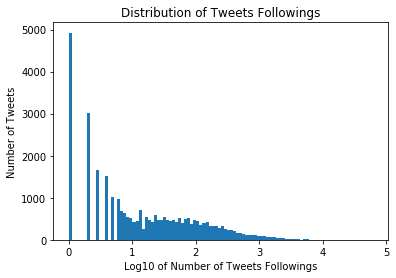

In [32]:
plt.hist(np.log10(df['following'].value_counts()),bins=100)
plt.title('Distribution of Tweets Followings')

plt.xlabel("Log10 of Number of Tweets Followings")
plt.ylabel("Number of Tweets")

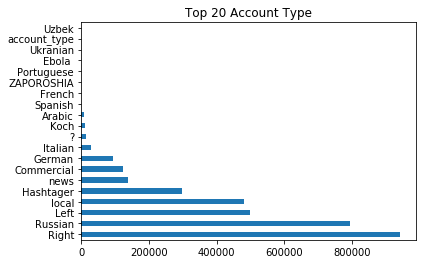

In [36]:
df['account_type'].value_counts()[:20].plot(kind='barh', title='Top 20 Account Type')

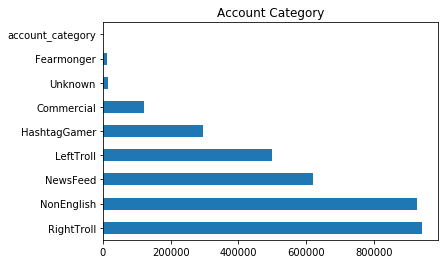

In [40]:
df['account_category'].value_counts().plot(kind='barh',title='Account Category')

# Tweeters mentioning Trump and Hillary 

In [6]:
#Extract tweets in English 
tf=df[df['language']=='English']
tf[['postdate','Time']]=tf.publish_date.str.split(' ', expand=True,)
tf[['hour','min']]=tf.Time.str.split(':', expand=True,)

print(tf.head())

/Users/jennyyu/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


   external_author_id  author  \
0  906000000000000000  10_GOP   
1  906000000000000000  10_GOP   
2  906000000000000000  10_GOP   
3  906000000000000000  10_GOP   
4  906000000000000000  10_GOP   

                                             content   region language  \
0  "We have a sitting Democrat US Senator on tria...  Unknown  English   
1  Marshawn Lynch arrives to game in anti-Trump s...  Unknown  English   
2  Daughter of fallen Navy Sailor delivers powerf...  Unknown  English   
3  JUST IN: President Trump dedicates Presidents ...  Unknown  English   
4  19,000 RESPECTING our National Anthem! #StandF...  Unknown  English   

      publish_date   harvested_date following followers updates  ...  \
0  10/1/2017 19:58  10/1/2017 19:59      1052      9636     253  ...   
1  10/1/2017 22:43  10/1/2017 22:43      1054      9637     254  ...   
2  10/1/2017 22:50  10/1/2017 22:51      1054      9637     255  ...   
3  10/1/2017 23:52  10/1/2017 23:52      1062      9642     256  ...

In [182]:
#Extract tweets mentinoning Trump and Hillary

def getmention(x):
    x=x.lower()
    try:
        if "trump" in x or 'donald' in x:
            if 'hillary' not in x and 'clinton' not in x:
                return 'Trump'
            elif 'hillary' in x or 'clinton' in x:
                return 'Both'
            else:
                return 'Trump'
        elif 'hillary' in x or 'clinton' in x:
            if 'trump' not in x and 'donald' not in x:
                return 'Hillary'
        else:
            return 'Non_Political'
    except:
        return 'Non_Political'
    
tf['label'] = tf['content'].astype('str').apply(getmention)


/Users/jennyyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(2497371, 28)

In [184]:
lab=['Trump','hillary','Both']
tf=tf[tf['label'].isin(lab)]
tf.shape

(331294, 28)

In [20]:
#stemming and lemmatizing the tweets 
import nltk
nltk.download('wordnet')

pt_stemmer = pt.PorterStemmer() 
lemmatizer = ns.WordNetLemmatizer()


def word2stemandlemma(word):
    word = pt_stemmer.stem(word)
    word = lemmatizer.lemmatize(word, pos='v')
    word = lemmatizer.lemmatize(word, pos='n')
    return word

df['contentnew']=df['content'].iloc[:1000].apply(word2stemandlemma)

[nltk_data] Downloading package wordnet to /Users/jennyyu/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [21]:
#Clean and tokenize the tweets

nltk.download('stopwords')
stop_words = stopwords.words('english')

#Remove @ and # and links
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

def replace_symbol(x):
    x = remove_pattern(x, "@[\w]*")  # remove @ and words after it
    x = remove_pattern(x, "#[\w]*")  # remove # and words after it
    x = x.split("https", maxsplit=1)[0]#remove links
    return x  
    
def clean(x):
    x=BeautifulSoup(x).get_text().lower()
    x=re.findall(r"\b[a-z]+\b",x)
    x=[w for w in x if not w in stop_words]
    return x

df['contentnew']=df['content'].iloc[:1000].apply(replace_symbol).apply(clean)
    
# tf['wordscount']=0
# tf['contentclean']=''
# for i in range(0, len(tf['content'])):
#     text=tf.iloc[i,2]
#     text=replace_symbol(text)
#     cleantext = BeautifulSoup(text).get_text().lower() #extract all text from tweets and remove capitalization
#     tokenizedText = re.findall(r"\b[a-z]+\b",cleantext)#extract all words from tweets
#     tf['wordscount'].iloc[i]=len(tokenizedText)#count words in the tweets
#     filteredToken = [w for w in tokenizedText if not w in stop_words]#remove stop words
#     tf['contentclean'].iloc[i]=filteredToken


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jennyyu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
print(df['contentnew'].head())


0    [sitting, democrat, us, senator, trial, corrup...
1    [marshawn, lynch, arrives, game, anti, trump, ...
2    [daughter, fallen, navy, sailor, delivers, pow...
3    [president, trump, dedicates, presidents, cup,...
4                       [respecting, national, anthem]
Name: contentnew, dtype: object


# Analysis with Tweets mentioning Trump or Hillary

In [2]:
#To improve computational cost, select 28000 tweets mentioning Trump or Hillary for further analysis
#Upload cleaned and tokenized tweets mentioning Trump and Hillary posted between Sep 1,2016 to Apr 1,2017

data= pd.read_excel('data.xlsx') 
print(data.head())
data.shape

  plabel     newDate                                            content  \
0  Trump  2017-01-10  marshawn lynch arriv game anti-trump shirt. ju...   
1  Trump  2017-01-10  just presid trump dedic presid golf tournament...   
2  Trump  2017-01-10  bongino: "nobodi troll liber better donald tru...   
3  Trump  2017-01-10  much hate promot article, admit everyth trump ...   
4  Trump  2017-02-10  presid trump first ladi melania trump lead whi...   

   external_author_id  author   region language     publish_date  \
0  906000000000000000  10_GOP  Unknown  English  10/1/2017 22:43   
1  906000000000000000  10_GOP  Unknown  English  10/1/2017 23:52   
2  906000000000000000  10_GOP  Unknown  English   10/1/2017 2:47   
3  906000000000000000  10_GOP  Unknown  English   10/1/2017 3:47   
4  906000000000000000  10_GOP  Unknown  English  10/2/2017 19:24   

    harvested_date  following  ...  account_type  retweet account_category  \
0  10/1/2017 22:43       1054  ...         Right        0     

(28107, 23)

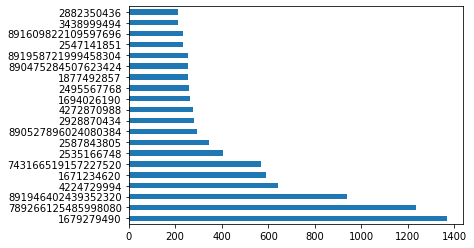

In [13]:
data['alt_external_id'].value_counts()[:20].plot(kind='barh')

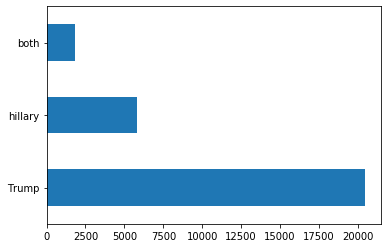

In [14]:
data['plabel'].value_counts().plot(kind='barh')

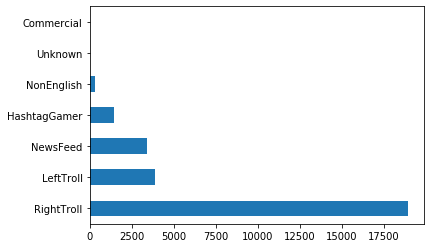

In [15]:
data['account_category'].value_counts().plot(kind='barh')

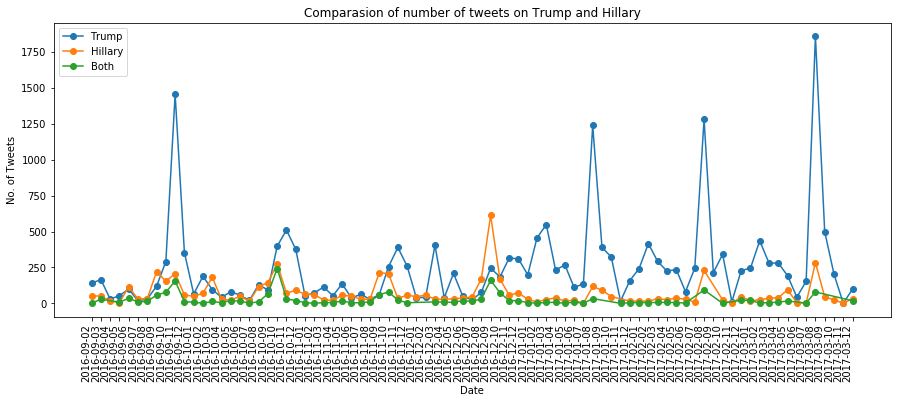

In [5]:
fig, ax = plt.subplots(figsize=(15, 6))
fig.autofmt_xdate(rotation=90 )
ax.set_xlabel("Date")
ax.set_ylabel("No. of Tweets")
fig, ax .set_title("Comparasion of number of tweets on Trump and Hillary")


n=range(len(data))
ax.plot(data.loc[data['plabel']=='Trump','newDate'].value_counts().sort_index(),marker='o', label='Trump')
ax.plot(data.loc[data['plabel']=='hillary','newDate'].value_counts().sort_index(),marker='o',label='Hillary')
ax.plot(data.loc[data['plabel']=='both','newDate'].value_counts().sort_index(),marker='o',label='Both')
ax.legend()
plt.show()

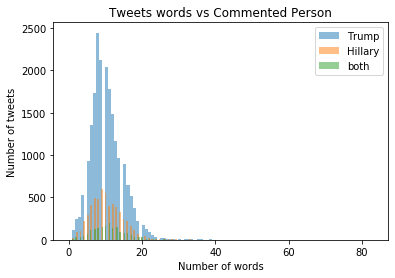

In [43]:
from matplotlib import pyplot

x=data.loc[data['plabel']=='Trump','conlen']
y=data.loc[data['plabel']=='hillary','conlen']
z=data.loc[data['plabel']=='both','conlen']
pyplot.hist(x ,alpha=0.5,bins=100,label='Trump')
pyplot.hist(y, alpha=0.5,bins=100,label='Hillary')
pyplot.hist(z, alpha=0.5,bins=100,label='both')

pyplot.legend(loc='upper right')

pyplot.title('Tweets words vs Commented Person')
pyplot.xlabel('Number of words')
pyplot.ylabel('Number of tweets')
pyplot.show()
# pyplot.hist(z, alpha=0.5, density=True,bins=50,label='Both')

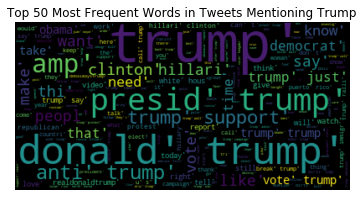

In [36]:
from wordcloud import WordCloud

def clean(text):
    cleantext = re.findall(r"\b[a-z]+\b",text)
    return cleantext

lab1=['Trump','both']
genre=data.loc[data['plabel'].isin(lab1),'content'].apply(clean)
                   
words = ','.join(str(i) for i in genre)
   
           
           
wordcloud = WordCloud()
wordcloud.generate(words)
           
           
plt.figure()
plt.max_words = 50
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Top 50 Most Frequent Words in Tweets Mentioning Trump")
plt.show()

# Analysize the word samilarity word2vec
 
Reference
https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92


In [39]:
from gensim.models import Word2Vec

# data['content']=data['content'].apply(clean)

# size: The number of dimensions of the embeddings and the default is 100.
# window: The maximum distance between a target word and words around the target word. The default window is 5.
# min_count: The minimum count of words to consider when training the model; words with occurrence less than this count will be ignored. The default for min_count is 5.
# workers: The number of partitions during training and the default workers is 3.
# sg: The training algorithm, either CBOW(0) or skip gram(1). The default training algorithm is CBOW.

model = Word2Vec(data['content'], min_count=1,size= 50,workers=3, window =3, sg = 1)

model.similarity('trump', 'hillary')
                    

/Users/jennyyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  del sys.path[0]


0.3486751

In [57]:
print('Word2Vec Analysis Results:Top 10 Most Similar Words to Trump\n', '-'*55, sep='')

model.most_similar('trump')

Word2Vec Analysis Results:Top 10 Most Similar Words to Trump
-------------------------------------------------------


/Users/jennyyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


[('bodyslam', 0.7730492949485779),
 ('violenc', 0.7729842662811279),
 ('cnn', 0.7689312696456909),
 ('lunch', 0.7674541473388672),
 ('lapd', 0.7631490230560303),
 ('suspens', 0.7575438022613525),
 ('storm', 0.753886342048645),
 ('survivor', 0.7537062168121338),
 ('announc', 0.7499938011169434),
 ('citizen', 0.7489492297172546)]

In [58]:
print('Word2Vec Analysis Results:Top 10 Most Similar Words to Hillary\n', '-'*55, sep='')
model.most_similar('hillary')

Word2Vec Analysis Results:Top 10 Most Similar Words to Hillary
-------------------------------------------------------


/Users/jennyyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('liberal', 0.8295009136199951),
 ('vot', 0.8217220902442932),
 ('stash', 0.8205822110176086),
 ('password', 0.8135576844215393),
 ('navarro', 0.7878189086914062),
 ('jasoninthehouse', 0.7873045802116394),
 ('triggered', 0.7792088389396667),
 ('cheat', 0.7757879495620728),
 ('find', 0.7746201753616333),
 ('prosecution', 0.7714560627937317)]

/Users/jennyyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  
/Users/jennyyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/Users/jennyyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


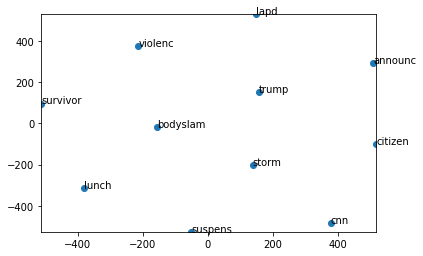

In [49]:
#Visualized the word samilarity with TSNE
from sklearn.manifold import TSNE

def display_closestwords_tsnescatterplot(model, word, size):
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]
    close_words = model.similar_by_word(word)
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
        
        
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

display_closestwords_tsnescatterplot(model, 'trump', 50) 